Arvid Lundervold, 2025-01-14

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/BMED365-2025/blob/main/Lab2-DL/notebooks/01-MNIST-Classification-with-Random-Forest.ipynb)

# NB 1: MNIST Classification using Random Forest

In [7]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")

Not running in Google Colab.


Loading MNIST data...

Total available MNIST samples: 70000
Using 1000 samples

MNIST Dataset Info:
Features (pixels): 784
Classes: 10

Class distribution:
0     95
1    104
2     95
3    119
4     88
5     90
6     97
7    103
8    101
9    108
Name: count, dtype: int64

Feature Statistics:
       pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
count   1000.0   1000.0   1000.0   1000.0   1000.0   1000.0   1000.0   1000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0

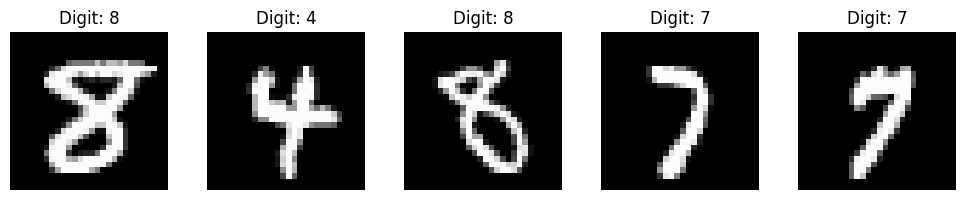


Feature Analysis:
Zero-variance features: 183
Features with >50% zeros: 18

Top 10 most correlated pixels with digit label:
pixel_436    0.412234
pixel_408    0.387704
pixel_409    0.382593
pixel_464    0.377986
pixel_381    0.368745
pixel_437    0.341691
pixel_263    0.328032
pixel_382    0.324502
pixel_354    0.319302
pixel_262    0.310973
Name: label, dtype: float64


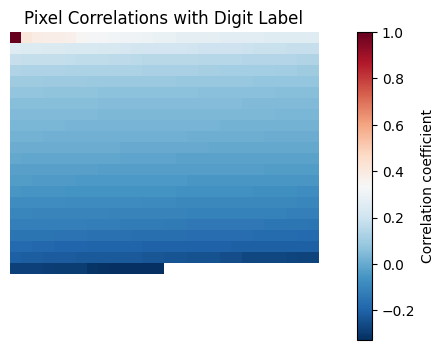

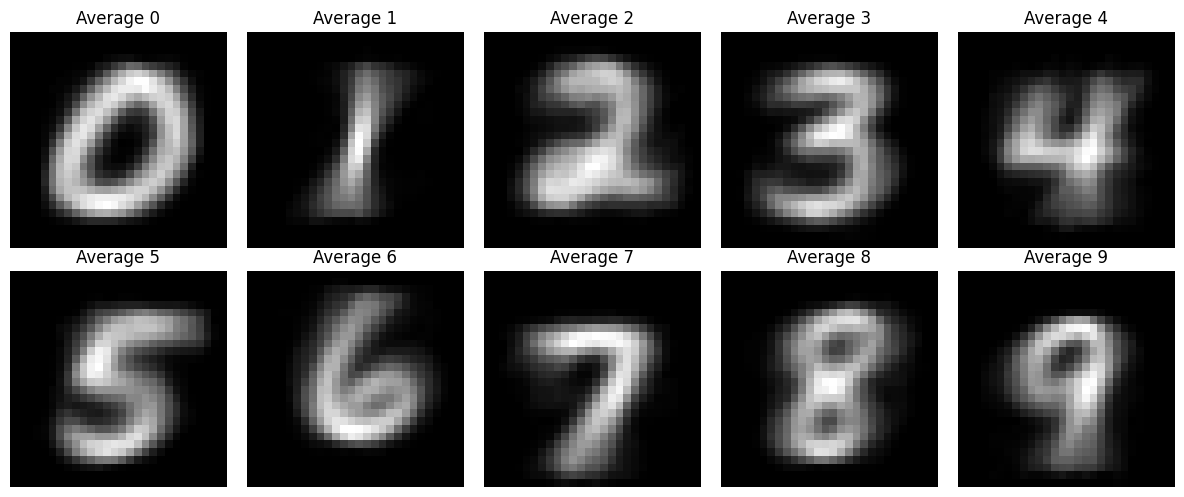

In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import os

def load_mnist_tabular(n_samples=None, random_state=42):
    """
    Load MNIST dataset as tabular data using scikit-learn
    
    Parameters:
    -----------
    n_samples : int, optional
        Number of samples to load. If None, loads all 70,000 samples.
        If n_samples is larger than 70,000, uses all available data.
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    X : array-like of shape (n_samples, 784)
        Each row is a flattened 28x28 image
    y : array-like of shape (n_samples,)
        Target labels (digits 0-9)
    """
    print("Loading MNIST data...")
    mnist = fetch_openml('mnist_784', version=1, as_frame=True, parser='auto')
    X = mnist.data.values / 255.0  # Scale to [0,1]
    y = mnist.target.astype(int).values  # Convert to numpy array
    
    total_samples = len(X)
    print(f"\nTotal available MNIST samples: {total_samples}")
    
    if n_samples is not None:
        # Make sure we don't try to sample more than available
        n_samples = min(n_samples, total_samples)
        print(f"Using {n_samples} samples")
        
        # Set random seed for reproducibility
        np.random.seed(random_state)
        
        # Take random subset
        indices = np.random.choice(total_samples, n_samples, replace=False)
        X = X[indices]
        y = y[indices]
    
    print("\nMNIST Dataset Info:")
    print(f"Features (pixels): {X.shape[1]}")
    print(f"Classes: {len(np.unique(y))}")
    print(f"\nClass distribution:")
    print(pd.Series(y).value_counts().sort_index())
    
    return X, y
# Load a subset of the data
n_desired_samples = 1000  # Adjust this up to 70,000 as needed
X, y = load_mnist_tabular(n_samples=n_desired_samples)

# Convert to DataFrame for exploration
feature_names = [f'pixel_{i}' for i in range(784)]
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

# Basic statistics
print("\nFeature Statistics:")
print(df.describe().round(3))

# Visualize examples
def plot_examples(X, y, n_examples=5):
    """Plot example digits"""
    fig, axes = plt.subplots(1, n_examples, figsize=(2*n_examples, 2))
    
    for i in range(n_examples):
        # Reshape to 28x28
        img = X[i].reshape(28, 28)
        
        # Plot
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Digit: {y[i]}')
    
    plt.tight_layout()
    plt.show()

# Plot first 5 examples
plot_examples(X, y)

# Feature analysis
print("\nFeature Analysis:")
print("Zero-variance features:", (df.var() == 0).sum())
print("Features with >50% zeros:", (df == 0).mean()[df.mean() > 0.5].count())

# Correlation with target
correlations = df.corr()['label'].sort_values(ascending=False)
print("\nTop 10 most correlated pixels with digit label:")
print(correlations[1:11])  # Skip 'label' itself

# Visualize feature correlations
plt.figure(figsize=(10, 4))
plt.title("Pixel Correlations with Digit Label")
correlation_map = correlations[:-1].values.reshape(28, 28)  # Exclude 'label'
plt.imshow(correlation_map, cmap='RdBu_r')
plt.colorbar(label='Correlation coefficient')
plt.axis('off')
plt.show()

# Optional: Show average digit images per class
def plot_average_digits(X, y):
    """Plot average image for each digit"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    for digit in range(10):
        digit_imgs = X[y == digit]
        avg_digit = digit_imgs.mean(axis=0).reshape(28, 28)
        
        axes[digit].imshow(avg_digit, cmap='gray')
        axes[digit].axis('off')
        axes[digit].set_title(f'Average {digit}')
    
    plt.tight_layout()
    plt.show()

plot_average_digits(X, y)

In [9]:
df.shape

(1000, 785)

In [10]:
df.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,...,1000.0,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000749,0.000502,0.0,0.0,0.0,0.0,0.0,0.0,4.536000
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.023686,0.015873,0.0,0.0,0.0,0.0,0.0,0.0,2.897775
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.749020,0.501961,0.0,0.0,0.0,0.0,0.0,0.0,9.000000


In [11]:
# Save the data to a CSV file  to mnist_images subdirectory

# Make a subdirectory for the images
os.makedirs('mnist_images', exist_ok=True)

df.to_csv(f'mnist_images/mnist_data_{n_desired_samples}x{df.shape[1]}.csv', index=False)
print(f"Data saved to 'mnist_images/mnist_data_{n_desired_samples}x{df.shape[1]}.csv'")

Data saved to 'mnist_images/mnist_data_1000x785.csv'


In [12]:
import os

def save_mnist_data(X, y, output_dir='mnist_images'):
    """
    Save MNIST images and create a CSV file with filenames and labels
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, 784)
        The image data
    y : array-like of shape (n_samples,)
        The labels
    output_dir : str
        Directory to save images and CSV
    """
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create list to store file information
    file_info = []
    
    # Save images and collect file info
    for i in range(len(X)):
        # Create filename with leading zeros
        filename = f'mnist_image_{i:04d}.png'
        filepath = os.path.join(output_dir, filename)
        
        # Save image
        img = X[i].reshape(28, 28)
        plt.imsave(filepath, img, cmap='gray')
        
        # Collect file info
        file_info.append({
            'file_name': filename,
            'label': int(y[i])
        })
    
    # Create and save DataFrame
    df_files = pd.DataFrame(file_info)
    csv_path = os.path.join(output_dir, 'mnist_labels.csv')
    df_files.to_csv(csv_path, index=False)
    
    print(f"Saved {len(X)} images to {output_dir}/")
    print(f"Saved labels to {csv_path}")
    print("\nFirst few rows of the CSV file:")
    print(df_files.head())
    
    return df_files

# After loading the MNIST data, save images and create CSV
df_mnist = save_mnist_data(X, y)

Saved 1000 images to mnist_images/
Saved labels to mnist_images/mnist_labels.csv

First few rows of the CSV file:
              file_name  label
0  mnist_image_0000.png      8
1  mnist_image_0001.png      4
2  mnist_image_0002.png      8
3  mnist_image_0003.png      7
4  mnist_image_0004.png      7


In [1]:
# Notebook 1: MNIST Classification using Random Forest
# ================================================
# This notebook demonstrates how to classify MNIST digits using a Random Forest
# classifier on the tabular representation of the data.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Data Loading and Preprocessing
# --------------------------------
print("Loading MNIST data from CSV...")
# Load training data
train_data = pd.read_csv('mnist_train.csv')
# Load test data
test_data = pd.read_csv('mnist_test.csv')

# Separate features and labels
X_train = train_data.drop('label', axis=1) / 255.0  # Normalize pixel values
y_train = train_data['label']
X_test = test_data.drop('label', axis=1) / 255.0
y_test = test_data['label']

# 2. Data Visualization
# --------------------
def plot_digit(data, index):
    """Plot a single MNIST digit."""
    digit = data.iloc[index, 1:].values.reshape(28, 28)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {data.iloc[index, 0]}")

# Plot a few example digits
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_digit(train_data, i)
plt.suptitle("Example MNIST Digits")
plt.show()

# 3. Model Training
# ----------------
print("Training Random Forest classifier...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# 4. Model Evaluation
# ------------------
print("Evaluating model performance...")
y_pred = rf_classifier.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 5. Feature Importance Analysis
# ----------------------------
# Get feature importance scores
importance = rf_classifier.feature_importances_
pixel_importance = importance.reshape(28, 28)

# Plot feature importance heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pixel_importance, cmap='viridis')
plt.title('Pixel Importance Heatmap')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

# 6. Example Predictions
# --------------------
# Select a few test examples
n_examples = 5
example_indices = np.random.randint(0, len(X_test), n_examples)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(example_indices):
    plt.subplot(1, 5, i+1)
    img = X_test.iloc[idx].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    pred = rf_classifier.predict([X_test.iloc[idx]])[0]
    true = y_test.iloc[idx]
    plt.title(f'Pred: {pred}\nTrue: {true}')
plt.suptitle("Example Predictions")
plt.show()

# 7. Save the Model (Optional)
# --------------------------
import joblib
joblib.dump(rf_classifier, 'mnist_random_forest.joblib')
print("\nModel saved as 'mnist_random_forest.joblib'")

Loading MNIST data from CSV...


FileNotFoundError: [Errno 2] No such file or directory: 'mnist_train.csv'